# **Modelo de regresión con HistGradientBoosting**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [3]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [4]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Función grafica mejor

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  HGBR = HistGradientBoostingRegressor(random_state=0)
  HGBR.fit(X_Entrenamiento, Y_Entrenamiento)

  Y_pred = HGBR.predict(X_Prueba)


  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión HistGradientBoostingRegresor') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión HistGradientBoostingRegresor') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de metricas

In [7]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función guardar resultados

In [8]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [9]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [10]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/hgbr_regressor.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)
       
        HGBR = HistGradientBoostingRegressor(random_state=0)
        HGBR.fit(X_Entrenamiento, Y_Entrenamiento)

        Y_pred = HGBR.predict(X_Prueba)

        result = puntaje(X_Prueba, Y_Prueba, Y_pred, HGBR, filename)
        df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [11]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
111,min_max_isf_400_0_2.csv,NaN,0.880080,-0.000008,8.568620e-07,0.871315,0.021513,0.880101,0.001582,0.029520,0.569178
96,min_max_isf_100_0_2.csv,NaN,0.878271,-0.000008,4.795193e-07,0.872229,0.015928,0.878276,0.001584,0.019978,0.288541
106,min_max_isf_300_0_2.csv,NaN,0.879503,-0.000008,5.771161e-07,0.875492,0.022458,0.879507,0.001617,0.026142,0.293535
101,min_max_isf_200_0_2.csv,NaN,0.872375,-0.000008,8.916480e-07,0.865223,0.017613,0.872408,0.001625,0.025078,0.607318
92,min_max_isf_100_auto.csv,NaN,0.888348,-0.000008,7.931310e-07,0.886155,0.019601,0.888362,0.001660,0.024108,0.558355
97,min_max_isf_200_auto.csv,NaN,0.886602,-0.000009,6.970697e-07,0.882471,0.018933,0.886603,0.001683,0.020640,0.841949
107,min_max_isf_400_auto.csv,NaN,0.887182,-0.000009,8.729417e-07,0.880747,0.017084,0.887182,0.001685,0.018519,0.580262
102,min_max_isf_300_auto.csv,NaN,0.882786,-0.000009,1.132206e-06,0.874983,0.014487,0.882810,0.001702,0.016578,0.223338
105,min_max_isf_300_0_15.csv,NaN,0.875585,-0.000012,1.775777e-06,0.863194,0.035649,0.875614,0.001800,0.025705,0.283215
95,min_max_isf_100_0_15.csv,NaN,0.883369,-0.000012,1.637341e-06,0.874828,0.021850,0.883369,0.001805,0.023613,0.490046


### Mejor resultado

In [12]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
111,min_max_isf_400_0_2.csv,NaN,0.88008,-0.000008,8.568620e-07,0.871315,0.021513,0.880101,0.001582,0.02952,0.569178


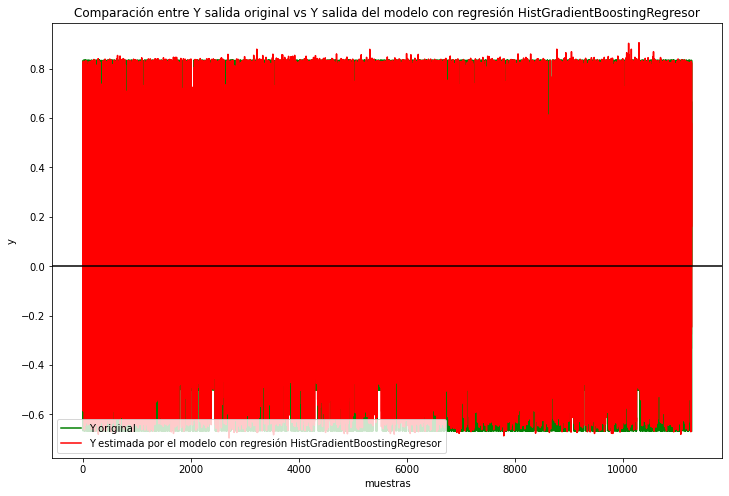

In [13]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
opc = df_resultados_medianos_sort.at[0,'CONFIG']
grafica_mejor(url, opc)

## Grandes

In [14]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/hgbr_regressor.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]

        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        HGBR = HistGradientBoostingRegressor(random_state=0)
        HGBR.fit(X_Entrenamiento, Y_Entrenamiento)

        Y_pred = HGBR.predict(X_Prueba)

        result = puntaje(X_Prueba, Y_Prueba, Y_pred, HGBR, filename)
        df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
estandar_original.csv
min_max_original.csv
max_normalizacion_original.csv
robusto_lof_euclidean_5.csv
robusto_lof_minkowski_5.csv
robusto_lof_manhattan_5.csv
robusto_lof_euclidean_7.csv
robusto_lof_minkowski_7.csv
robusto_lof_manhattan_7.csv
robusto_lof_euclidean_9.csv
robusto_lof_minkowski_9.csv
robusto_lof_manhattan_9.csv
robusto_lof_euclidean_11.csv
robusto_lof_minkowski_11.csv
robusto_lof_manhattan_11.csv
estandar_lof_euclidean_5.csv
estandar_lof_minkowski_5.csv
estandar_lof_manhattan_5.csv
estandar_lof_euclidean_7.csv
estandar_lof_minkowski_7.csv
estandar_lof_manhattan_7.csv
estandar_lof_euclidean_9.csv
estandar_lof_minkowski_9.csv
estandar_lof_manhattan_9.csv
estandar_lof_euclidean_11.csv
estandar_lof_minkowski_11.csv
estandar_lof_manhattan_11.csv
min_max_lof_euclidean_5.csv
min_max_lof_minkowski_5.csv
min_max_lof_manhattan_5.csv
min_max_lof_euclidean_7.csv
min_max_lof_minkowski_7.csv
min_max_lof_manhattan_7.csv
min_max_lof_euclidean_9.csv
min_max_lof_minkows

In [15]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
30,min_max_lof_manhattan_5.csv,NaN,0.958215,-0.000101,0.000036,0.903765,0.021283,0.958215,0.001119,0.000644,0.332907
29,min_max_lof_minkowski_5.csv,NaN,0.959979,-0.000092,0.000046,0.915255,0.053368,0.959979,0.001129,0.000748,0.434208
28,min_max_lof_euclidean_5.csv,NaN,0.959979,-0.000092,0.000046,0.915255,0.053368,0.959979,0.001129,0.000748,0.434208
39,min_max_lof_manhattan_11.csv,NaN,0.962276,-0.000082,0.000041,0.902807,0.038033,0.962276,0.001136,0.000986,0.310533
33,min_max_lof_manhattan_7.csv,NaN,0.958511,-0.000083,0.000021,0.915087,0.040538,0.958513,0.001138,0.000685,0.360186
34,min_max_lof_euclidean_9.csv,NaN,0.946729,-0.000091,0.000024,0.912032,0.030238,0.946729,0.001143,0.001069,0.599300
35,min_max_lof_minkowski_9.csv,NaN,0.946729,-0.000091,0.000024,0.912032,0.030238,0.946729,0.001143,0.001069,0.599300
36,min_max_lof_manhattan_9.csv,NaN,0.940462,-0.000078,0.000027,0.914085,0.041290,0.940464,0.001181,0.001641,0.994254
37,min_max_lof_euclidean_11.csv,NaN,0.945265,-0.000113,0.000046,0.867232,0.056444,0.945265,0.001197,0.000820,0.678219
38,min_max_lof_minkowski_11.csv,NaN,0.945265,-0.000113,0.000046,0.867232,0.056444,0.945265,0.001197,0.000820,0.678219


### Mejor resultado

In [16]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
30,min_max_lof_manhattan_5.csv,NaN,0.958215,-0.000101,0.000036,0.903765,0.021283,0.958215,0.001119,0.000644,0.332907


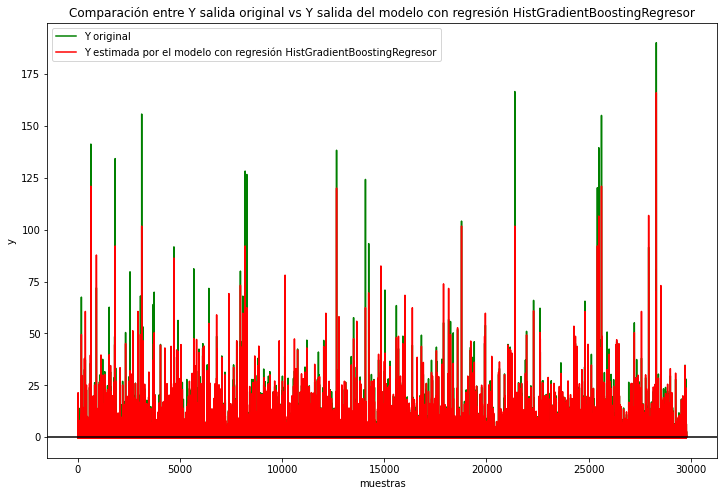

In [17]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
opc = df_resultados_grandes_sort.at[0,'CONFIG']
grafica_mejor(url, opc)